## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [19]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
import keras
import tensorflow_addons as tfa
import keras.backend as K
from tqdm import tqdm
plt.style.use("seaborn")
import torch
from torch import nn, optim
import torch.nn.functional as F

In [20]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [21]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [23]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

KeyError: 'Class'

## Compare hists between classes

In [24]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [86]:
# print("Differences between fraud and non-fraud:")
# for i in records0.keys():
#     print("Differences in",i)
#     print("Median:", records0[i].median()-records1[i].median())
#     print("Mean:", records0[i].mean()-records1[i].mean())
#     print("Std:", records0[i].std()-records1[i].std())
    
#     print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [25]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
top10_perm = ['V14','V12','V17','V10','V4','V16','V7','V2','V11','Amount']
X_median = normalized_records[top10].to_numpy()
y = targets.to_numpy()

X_perm = normalized_records[top10_perm].to_numpy()
X_all = normalized_records.to_numpy()

### Performance Metrics
The function below calculates a series of performance metrics.
1. Accuracy - This is the default metric and is not suited for this problem.
2. False negatives, False positives, True positives - Gives insight in how it classifies.
3. F1 score - Is considered suited for imbalanced datasets.
4. AUPRC - Area Under Precision-Recall Curve is the suggested metric from Kaggle.
5. AUC ROC - Area Under Curve Receiving Operating Characteristic is widely used for this specific task, but not good for imbalanced datasets
6. Average Precision - Should be a good overall measure for this task. 
7. Mean score for metrics - The mean for 3, 4, 5, 6

In [32]:
#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name="", verbose=False, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    _, X_test, _, y_test = dataset
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    f1 = f1_score(preds, y_test)
    aucroc = auc(fpr, tpr)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, preds_proba)
    mean_score = np.mean([f1, auprc, aucroc, avg_precision])
    
    if verbose:
        cm = confusion_matrix(preds, y_test)
        tn, fp, fn, tp = cm.ravel()
        
        print("{} performance metrics:\n-=-=-=-=-=-".format(name))
        print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
        print("False negatives:", fn)
        print("False positives:", fp)
        print("True positives:", tp)
        print("F1 score:", f1)

        print("AUPRC:", auprc)
        print("AUC ROC:", aucroc)
        print("Average Precision Score:", avg_precision)
        print("Mean Score for Metrics:", mean_score)
        print()
    
    return [f1, auprc, aucroc, avg_precision, mean_score]

def print_scores(scores, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    print("F1 score:", scores[0])
    print("AUPRC:", scores[1])
    print("AUC ROC:", scores[2])
    print("Average Precision Score:", scores[3])
    print("Mean Score for Metrics:", scores[4])
    print()

def AUC_PR(preds_proba, y):
    precision, recall, _ = precision_recall_curve(y, preds_proba)
    auprc = auc(recall, precision)
    return auprc

def preds_to_auprc(pred_dict):
    if pred_dict['all'].shape[1]>1:
        pred_dict['all'] = pred_dict['all'][:,1]
        pred_dict['median'] = pred_dict['median'][:,1]
        pred_dict['perm'] = pred_dict['perm'][:,1]
    
    all_auc = AUC_PR(pred_dict['all'], y_all_test)
    med_auc = AUC_PR(pred_dict['median'], y_median_test)
    perm_auc = AUC_PR(pred_dict['perm'], y_perm_test)
    return all_auc, med_auc, perm_auc

## Evaluation
Using Stratified K-fold and the metrics above

In [26]:
oversample = imblearn.over_sampling.SMOTE()

#All dataset
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, random_state=42)
X_all_smote, y_all_smote = oversample.fit_resample(X_all_train, y_all_train)

#Top 10 median dataset
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y, random_state=42)
X_median_smote, y_median_smote = oversample.fit_resample(X_median_train, y_median_train)

#Top 10 perm dataset
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y, random_state=42)
X_perm_smote, y_perm_smote = oversample.fit_resample(X_perm_train, y_median_train)

In [53]:
skf = StratifiedKFold(n_splits=5)

In [120]:

lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
nbc = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[1000,200], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


def cross_val_train_model(model, name="", dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset 
    
    accuracies = []
    for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
        X_strat_train, X_valid = X_train[train_index], X_train[valid_index]
        y_strat_train, y_valid = y_train[train_index], y_train[valid_index]

        model.fit(X_strat_train, y_strat_train)
        accuracies.append(evaluate_model(model, dataset=dataset))

    print_scores(np.mean(accuracies, axis=0), name=name)

def model_prediction(model, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

In [110]:
#cross_val_train_model(dum, name="Baseline", dataset=(X_median_smote, X_median_test, y_median_smote, y_median_test))
# cross_val_train_model(lrg, name="Logistic Regression")
# cross_val_train_model(knn, name="K-Nearest neighbours")
# cross_val_train_model(rfc, name="Random Forest")
# cross_val_train_model(nb, name="Naive Bayes")
# cross_val_train_model(mlp, name="Multilayer Perceptron")

In [121]:
def train_on_all_sets(model, name=""):
    #Function does 5-fold cross validation and returns predictions on test set. 
    datasets = {
        'all' : (X_all_smote, X_all_test, y_all_smote, y_all_test),
        'median' : (X_median_smote, X_median_test, y_median_smote, y_median_test),
        'perm' : (X_perm_smote, X_perm_test, y_perm_smote, y_perm_test)
    }
    preds = {
        'all' : None,
        'median' : None,
        'perm' : None
    }
    for dataset in datasets:
        cross_val_train_model(model, name="{}_{}".format(name, dataset), dataset=datasets[dataset])
        preds[dataset] = model_prediction(model, dataset=datasets[dataset])
    
    return preds

In [122]:
dum_preds = train_on_all_sets(dum, name="Baseline")
lrg_preds = train_on_all_sets(lrg, name="Logistic Regression")
mlp_preds = train_on_all_sets(mlp, name="Multilayer Perceptron")
rfc_preds = train_on_all_sets(rfc, name="Random Forest")
nbc_preds = train_on_all_sets(nbc, name="Naive Bayes")

5it [00:00,  7.38it/s]
1it [00:00,  7.77it/s]

Baseline_all performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [00:00,  9.44it/s]
1it [00:00,  6.31it/s]

Baseline_median performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [00:00,  9.18it/s]
0it [00:00, ?it/s]

Baseline_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [01:14, 14.93s/it]


Logistic Regression_all performance metrics:
-=-=-=-=-=-
F1 score: 0.10145712853414586
AUPRC: 0.7641884147257637
AUC ROC: 0.9776063209809166
Average Precision Score: 0.7241036401982139
Mean Score for Metrics: 0.64183887610976



5it [00:07,  1.57s/it]


Logistic Regression_median performance metrics:
-=-=-=-=-=-
F1 score: 0.09928810532391544
AUPRC: 0.7346279747515722
AUC ROC: 0.9769084422032608
Average Precision Score: 0.727644421336276
Mean Score for Metrics: 0.6346172359037561



5it [00:08,  1.66s/it]


Logistic Regression_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.09865114295269871
AUPRC: 0.7333503805288295
AUC ROC: 0.9766535454684313
Average Precision Score: 0.7345513215728412
Mean Score for Metrics: 0.6358015976307002



5it [2:35:14, 1862.98s/it]


Multilayer Perceptron_all performance metrics:
-=-=-=-=-=-
F1 score: 0.7555006493936492
AUPRC: 0.8172491603410876
AUC ROC: 0.9640903954745996
Average Precision Score: 0.8167369749950024
Mean Score for Metrics: 0.8383942950510848



5it [4:13:22, 3040.43s/it]


Multilayer Perceptron_median performance metrics:
-=-=-=-=-=-
F1 score: 0.6323557182221127
AUPRC: 0.759904686870822
AUC ROC: 0.9663066999275619
Average Precision Score: 0.7608573403873474
Mean Score for Metrics: 0.779856111351961



5it [4:24:37, 3175.57s/it]


Multilayer Perceptron_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.5862709508954747
AUPRC: 0.764449848078811
AUC ROC: 0.9647102217748487
Average Precision Score: 0.7651221344686394
Mean Score for Metrics: 0.7701382888044435



5it [16:35, 199.10s/it]


Random Forest_all performance metrics:
-=-=-=-=-=-
F1 score: 0.8372169606001189
AUPRC: 0.8708098694420794
AUC ROC: 0.9868222023072908
Average Precision Score: 0.8701309380323426
Mean Score for Metrics: 0.891244992595458



5it [10:05, 121.12s/it]


Random Forest_median performance metrics:
-=-=-=-=-=-
F1 score: 0.7598569948965721
AUPRC: 0.8393757932716012
AUC ROC: 0.9787847266613445
Average Precision Score: 0.8290123910797108
Mean Score for Metrics: 0.8517574764773072



5it [09:46, 117.28s/it]


Random Forest_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.7698672565382448
AUPRC: 0.8357502390738146
AUC ROC: 0.9681135214153217
Average Precision Score: 0.828446364625367
Mean Score for Metrics: 0.8505443454131871



5it [00:02,  2.49it/s]


Naive Bayes_all performance metrics:
-=-=-=-=-=-
F1 score: 0.10681756340680408
AUPRC: 0.4216006769214535
AUC ROC: 0.9631797458925039
Average Precision Score: 0.0841053674639757
Mean Score for Metrics: 0.39392583842118434



5it [00:00,  5.15it/s]
0it [00:00, ?it/s]

Naive Bayes_median performance metrics:
-=-=-=-=-=-
F1 score: 0.15846482064283995
AUPRC: 0.5279829549350588
AUC ROC: 0.9627679474949573
Average Precision Score: 0.25389319222480017
Mean Score for Metrics: 0.4757772288244141



5it [00:00,  5.18it/s]

Naive Bayes_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.14484572266089396
AUPRC: 0.5077910860463386
AUC ROC: 0.9586160411907946
Average Precision Score: 0.2401902264281462
Mean Score for Metrics: 0.4628607690815433



In [142]:
# Definition of NN structure

class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x))



# Accuracy function, as percentage of true predictions
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)



In [143]:
%%time

epochs_ = 300

# X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, random_state=42)
# X_all_smote, y_all_smote = oversample.fit_resample(X_all_train, y_all_train)

# #Top 10 median dataset
# X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y, random_state=42)
# X_median_smote, y_median_smote = oversample.fit_resample(X_median_train, y_median_train)

# #Top 10 perm dataset
# X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y, random_state=42)
# X_perm_smote, y_perm_smote = oversample.fit_resample(X_perm_train, y_median_train)


datasets = {
    'all' : (X_all_smote, X_all_test, y_all_smote, y_all_test),
    'median' : (X_median_smote, X_median_test, y_median_smote, y_median_test),
    'perm' : (X_perm_smote, X_perm_test, y_perm_smote, y_perm_test)
}
py_preds = {
    'all' : None,
    'median' : None,
    'perm' : None
}
for dataset in datasets:
    
    temp_X, temp_y = datasets[dataset][0], datasets[dataset][2]
    temp_X_test, temp_y_test = datasets[dataset][1], datasets[dataset][3]

    # Create torch train/validation data sets
    net = Net(temp_X.shape[1]) 

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    accuracies = []
    histories = []
    for train_index, valid_index in tqdm(skf.split(temp_X, temp_y)):
        X_strat_train, X_validation =  torch.from_numpy(temp_X[train_index]).float(),  torch.from_numpy(temp_X[valid_index]).float()
        y_strat_train, y_validation =  torch.from_numpy(temp_y[train_index]).float(),  torch.from_numpy(temp_y[valid_index]).float()

        losses = []
        for epoch in tqdm(range(epochs_)):
            
            y_strat_pred = net(X_strat_train)
            
            y_strat_pred = torch.squeeze(y_strat_pred)
            train_loss = criterion(y_strat_pred, y_strat_train)
            
            

            if epoch % 100 == 0:
                train_acc = calculate_accuracy(y_strat_train, y_strat_pred)

                y_test_pred = net(X_validation)
                y_test_pred = torch.squeeze(y_test_pred)

                test_loss = criterion(y_test_pred, y_validation)
                test_acc = calculate_accuracy(y_test_pred, y_validation)
                
            losses.append(round_tensor(train_loss))
            
            #accuracies.append(AUC_PR(net(temp_X_test), temp_y_test))
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        history_record = {} 
        history_record['loss'] = losses
        history_record['val_loss'] = []
        histories.append(history_record)

    py_preds[dataset] = net(torch.from_numpy(temp_X_test).float().detach())
    


 4.82s/it]
100%|██████████| 300/300 [24:30<00:00,  4.90s/it]
4it [1:34:26, 1416.03s/it]
100%|██████████| 300/300 [23:44<00:00,  4.75s/it]
5it [1:58:10, 1418.13s/it]
Wall time: 6h 3min 3s


In [147]:
losses = [np.array(x['loss']) for x in histories]


In [144]:
py_preds['all'] = py_preds['all'].detach()
py_preds['median'] = py_preds['median'].detach()
py_preds['perm'] = py_preds['perm'].detach()

In [145]:
save_features(py_preds, filename="pytorch_predictions")


Features saved! :-)


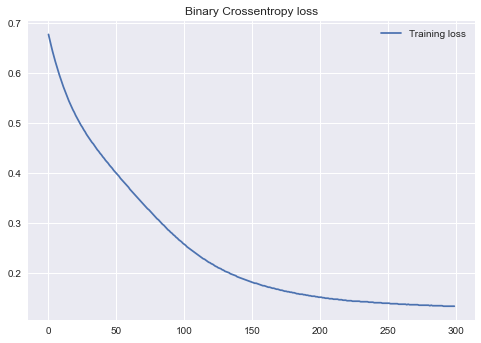

In [159]:
plt.plot(histories[0]['loss'], label="Training loss")
plt.title("Binary Crossentropy loss")
plt.legend()

In [174]:
#print(confusion_matrix(nn_preds['all'].astype(int), y_all_test))
print(confusion_matrix(py_preds['all'].int(), y_all_test))
print(confusion_matrix(py_preds['median'].int(), y_median_test))
print(confusion_matrix(py_preds['perm'].int(), y_perm_test))

[[71078    62]
 [   11    51]]
[[71077    52]
 [   12    61]]
[[71078    63]
 [   11    50]]


In [1]:
#Copied this function from a previous project, hence the misleading name.
import pickle
def save_features(feature_dict, filename='features'):
    '''Save the updated feature dictionary. Takes dictionary as input and saves as binary file
    
    example: 
    >>> my_featues = {'freqdist': [1,6,3,5]}
    >>> save_features(my_features)'''
    
    with open('data/{}.dat'.format(filename), 'wb') as file:
        pickle.dump(feature_dict, file)
    print("Features saved! :-)")

def load_features(filename='features'):
    '''Load feature dictionary. Returns the saved feature as a dictionary.
    
    example: 
    >>> my_features = load_features()'''
    
    with open('data/{}.dat'.format(filename), 'rb') as file:
        feats = pickle.load(file)
    print("Features available:")
    
    if type(feats) != dict:
        return feats
    for i in feats.keys():
        print(i)
    return feats

In [102]:
# nn_preds = load_features(filename="nn_preds")
# py_preds = load_features(filename="pytorch_predictions")
# sklearn_predictions = load_features(filename="sklearn_predictions")
histories = load_features(filename="histories")
# accuracies = load_features(filename="accuracies")

Features available:


Text(0.5, 1.0, 'Binary Crossentropy loss')

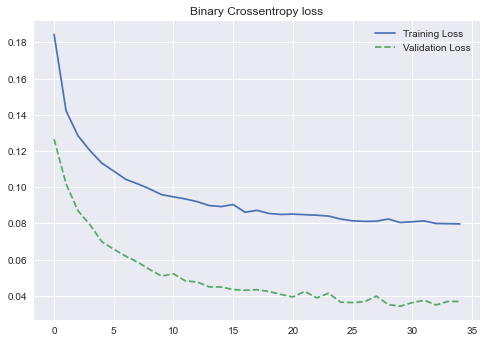

In [45]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], '--', label="Validation Loss")
plt.legend()
plt.title("Binary Crossentropy loss")

0.7764051352769953
0.7628282293920176
0.7671477592783972
0.7619393825614128


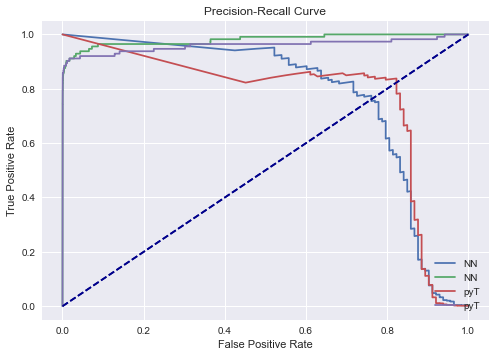

In [173]:
create_pr_curve(nn_preds['all'], y_all_test, label="NN", title="Precision-Recall Curve")
create_roc_curve(nn_preds['all'], y_all_test, label="NN", title="Precision-Recall Curve")

create_pr_curve(py_preds['all'], y_all_test, label="pyT", title="Precision-Recall Curve")
create_roc_curve(py_preds['all'], y_all_test, label="pyT", title="Precision-Recall Curve")

print(AUC_PR(nn_preds['all'], y_all_test))

print(AUC_PR(py_preds['all'],y_all_test))
print(AUC_PR(py_preds['median'],y_median_test))
print(AUC_PR(py_preds['perm'],y_perm_test))

### Saving Results

In [127]:
model_predictions = {
    'dum' : dum_preds,
    'lrg' : lrg_preds,
    'mlp' : mlp_preds,
    'rfc' : rfc_preds,
    'nbc' : nbc_preds,
}
#save_features(model_predictions, filename="sklearn_predictions")

Features saved! :-)


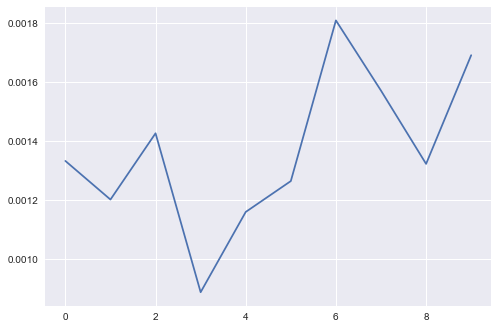

In [149]:
plt.plot(history.history['val_loss'], label="val loss")

In [122]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': [1000, 200],
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [119]:
evaluate_model(lrg, verbose=True)

 performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9989887924496503
False negatives: 21
False positives: 51
True positives: 60
F1 score: 0.625
AUPRC: 0.660891641643524
AUC ROC: 0.9598326013062055
Average Precision Score: 0.6622137705085297
Mean Score for Metrics: 0.7269845033645649



[0.625,
 0.660891641643524,
 0.9598326013062055,
 0.6622137705085297,
 0.7269845033645649]

In [16]:
def plot_roc_cur(fper, tper, label="", line="", title="plot title"):
    plt.plot(fper, tper, line, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", line="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, line=line, title=title)

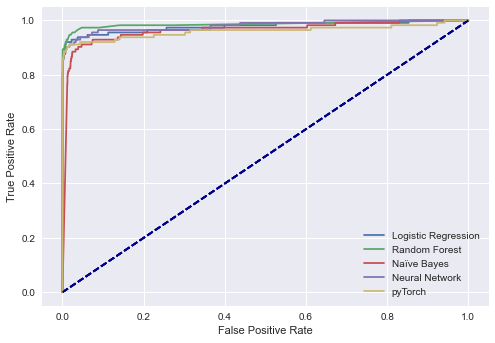

In [150]:
create_roc_curve(sklearn_predictions['lrg']['all'][:,1], y_all_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(sklearn_predictions['rfc']['all'][:,1], y_all_test, label="Random Forest")
create_roc_curve(sklearn_predictions['nbc']['all'][:,1], y_all_test, label="Naïve Bayes")
#create_roc_curve(sklearn_predictions['mp']['all'][:,1], y_all_test, label="Multilayer Perceptron")
create_roc_curve(nn_preds['all'], y_all_test, label="Neural Network")
create_roc_curve(py_preds['all'], y_all_test, label="pyTorch")

## Precicion Recall Curve

In [10]:
def plot_pr_cur(p, r, label="", line="", title="plot title"):
    plt.plot(r, p, line, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    
def create_pr_curve(preds, targets, label="", line="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title, line=line)

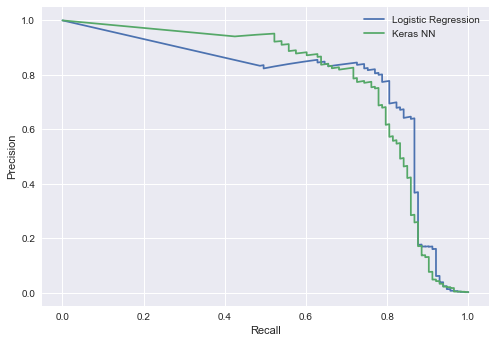

In [47]:
create_pr_curve(sklearn_predictions['lrg']['all'][:,1], y_all_test, label="Logistic Regression")
# create_pr_curve(mlp_preds['all'][:,1], y_all_test, label="Multilayer Perceptron")
# create_pr_curve(rfc_preds['all'], y_all_test, line='-.', label="Random Forest")
# create_pr_curve(nbc_preds['all'][:,1], y_all_test, label="Naive Bayes")
create_pr_curve(nn_preds['all'], y_all_test, label="Keras NN")
# create_pr_curve(py_preds['all'], y_all_test, label="pyTorch NN")
# create_pr_curve(dum_preds['all'], y_all_test, label="Baseline", line='--', title="Precision-Recall Curve - All Features")

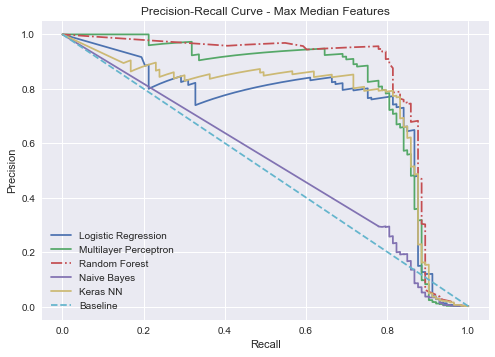

In [175]:
create_pr_curve(lrg_preds['median'], y_median_test, label="Logistic Regression")
create_pr_curve(mlp_preds['median'][:,1], y_median_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['median'], y_median_test, line='-.', label="Random Forest")
create_pr_curve(nbc_preds['median'][:,1], y_median_test, label="Naive Bayes")
create_pr_curve(nn_preds['median'], y_median_test, label="Keras NN")
create_pr_curve(py_preds['median'], y_median_test, label="pyTorch NN")
create_pr_curve(dum_preds['median'], y_median_test, label="Baseline", line='--', title="Precision-Recall Curve - Max Median Features")

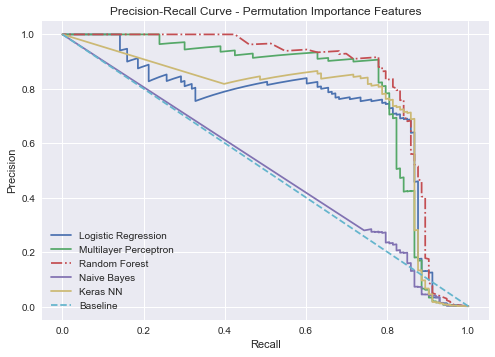

In [173]:
create_pr_curve(lrg_preds['perm'], y_perm_test, label="Logistic Regression")
create_pr_curve(mlp_preds['perm'][:,1], y_perm_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['perm'], y_perm_test, line='-.', label="Random Forest")
create_pr_curve(nbc_preds['perm'][:,1], y_perm_test, label="Naive Bayes")
create_pr_curve(nn_preds['perm'], y_perm_test, label="Keras NN")
create_pr_curve(py_preds['perm'], y_perm_test, label="pyTorch NN")
create_pr_curve(dum_preds['perm'], y_perm_test, label="Baseline", line='--', title="Precision-Recall Curve - Permutation Importance Features")

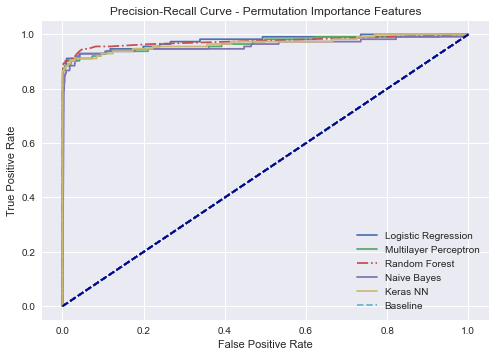

In [177]:
create_roc_curve(lrg_preds['perm'], y_perm_test, label="Logistic Regression")
create_roc_curve(mlp_preds['perm'][:,1], y_perm_test, label="Multilayer Perceptron")
create_roc_curve(rfc_preds['perm'], y_perm_test, line='-.', label="Random Forest")
create_roc_curve(nbc_preds['perm'][:,1], y_perm_test, label="Naive Bayes")
create_roc_curve(nn_preds['perm'], y_perm_test, label="Keras NN")
create_roc_curve(py_preds['perm'], y_perm_test, label="pyTorch NN")
create_roc_curve(dum_preds['perm'], y_perm_test, label="Baseline", line='--', title="Precision-Recall Curve - Permutation Importance Features")